In [1]:
%matplotlib inline
from IPython.display import display, clear_output
import simpy as sp
from concurrent.futures import ProcessPoolExecutor
import myutils as mu
import time
import datetime as dt
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
plt.rcParams['animation.embed_limit'] = 2**128

In [2]:
G = mu.load_map()

In [3]:
class StationModel():
    stations = set()
    def __init__(self, routeId, varId) -> None:
        src = mu.STOPS_FILE_NAME + str(varId)
        api = mu.STOPS_API(id=routeId, varId=varId)
        stops_df = mu.load_data(route=routeId, source=src, api=api)
        stops_df = stops_df[["StopId", "Lat", "Lng"]]
        self.stops_df = stops_df.rename(columns={"StopId":"stop_id", "Lat":"lat", "Lng":"lng"})

        StationModel.stations.update(self.stops_df["stop_id"].tolist())

In [11]:
class BusModel():
    X = dict()
    Y = dict()

    def __init__(self, id) -> None:
        self.route = id
        timetables_df = mu.load_data(route=id, source=mu.TIMETABLE_FILE_NAME, api=mu.TIMETABLE_API(id))
        
        self.vars = list()
        self.stations = dict()
        self.paths_df = dict()
        self.trips_df = dict()
        self.bus_num = dict()
        for i, row in timetables_df.iterrows():
            varId = row["RouteVarId"]
            self.bus_num[varId] = 0
            self.vars.append(varId)
    
            self.stations[varId] = StationModel(routeId=id, varId=varId)

            src = mu.PATHS_FILE_NAME + str(varId)
            self.paths_df[varId] = mu.load_data(route=id, source=src, api=mu.PATHS_API(id=id, varId=varId))
        
            tripId = row["TimeTableId"]
            src = mu.TRIPS_FILE_NAME + str(varId)
            trip_df = mu.load_data(route=id, source=src, api=mu.TRIPS_API(id=id, tripId=tripId))
            trip_df = trip_df[["StartTime", "EndTime"]]
            self.trips_df[varId] = trip_df.rename(columns={"StartTime":"start", "EndTime":"end"})
            self.trips_df[varId] = self.trips_df[varId].applymap(lambda t: time.strptime(t,'%H:%M'))
            self.trips_df[varId] = self.trips_df[varId].applymap(lambda t: dt.timedelta(hours=t.tm_hour,minutes=t.tm_min,seconds=t.tm_sec).total_seconds())

    def prepare_path(self):
        is_used_local = False

        for varId in self.vars:
            source = mu.DF_FILE_NAME + str(varId)
            try:
                eval_columns = ["edge", "route"]
                self.paths_df[varId] = mu.load_path_data(route=self.route, source=source, eval_columns=eval_columns)
                is_used_local = True
            except FileNotFoundError:
                break

        if is_used_local: return

        with ProcessPoolExecutor() as executor:
            params = [(varId, self.paths_df[varId], self.stations[varId].stops_df, G) for varId in self.vars]
            results = executor.map(mu.get_routes_from_paths, params)
            for result in results:
                id, df = result
                self.paths_df[id] = df
                mu.save_path_data(route=self.route, var=id, df=df)

    def prepare_graph(self):
        self.station_num = {var: self.paths_df[var][self.paths_df[var]["station"]].shape[0] for var in self.vars}
        self.station_max = self.station_num[max(self.station_num, key=lambda id: self.station_num[id])]
        
        self.path_count = {var: self.paths_df[var].shape[0] for var in self.vars}
        self.path_max = self.path_count[max(self.path_count, key=lambda id: self.path_count[id])]
        
        self.x = {var: self.paths_df[var].apply(lambda path: G.nodes[path["edge"][0]]["x"], axis="columns") for var in self.vars}
        self.max_x = self.x[max(self.x, key=lambda id: self.x[id].max())].max()
        self.min_x = self.x[min(self.x, key=lambda id: self.x[id].min())].min()

        self.y = {var: self.paths_df[var].apply(lambda path: G.nodes[path["edge"][0]]["y"], axis="columns") for var in self.vars}
        self.max_y = self.y[max(self.y, key=lambda id: self.y[id].max())].max()
        self.min_y = self.y[min(self.y, key=lambda id: self.y[id].min())].min()

        self.travel_time = {var: self.paths_df[var]["travel_times"].sum() for var in self.vars}

    def setup(self, env, oneday):
        bus_nums = {
            var: self.trips_df[var][
                    self.trips_df[var].apply(lambda trip: trip["start"] - self.trips_df[var].loc[0, "start"], axis="columns") < self.travel_time[var]
                ].shape[0]
            for var in self.vars
        }
        bus_num = bus_nums[max(bus_nums, key=lambda x: bus_nums[x])] + 2
        self.buses = {var: sp.Store(env, bus_num) for var in self.vars}
        for var, store in self.buses.items():
            for i in range(bus_num):
                bus_id = f"Bus:{self.route}:{var}:{i}"
                store.put(bus_id)
                
        BusModel.X[self.route] = dict()
        BusModel.Y[self.route] = dict()

        self.env = env
        self.oneday = oneday

        for var in self.vars:
            station = self.stations[var].stops_df
            station["node"] = mu.ox.nearest_nodes(G, X=station["lng"], Y=station["lat"])

    @classmethod
    def get_coord(cls):
        X_values = dict()
        Y_values = dict()
        for route in cls.X:
            X_values[route] = [cls.X[route][id] for id in cls.X[route]]
            Y_values[route] = [cls.Y[route][id] for id in cls.Y[route]]
        return X_values, Y_values

    def start_route(self, var, outbound, bus_id):
        for i, path in self.paths_df[var].iterrows():
            if path["station"]:
                # station = self.stations[var].stops_df
                # stop_id = station.loc[station['node'] == path["node"], "stop_id"]
                # print(f"{bus} has arrive at station {stop_id.iloc[0]}")
                pass
            
            BusModel.X[self.route][bus_id] = self.x[var].iloc[i]
            BusModel.Y[self.route][bus_id] = self.y[var].iloc[i]

            yield self.env.timeout(path["travel_times"])
            if i == self.path_count[var] - 1:
                pass

        del BusModel.X[self.route][bus_id]
        del BusModel.Y[self.route][bus_id]
        yield self.buses[outbound].put(bus_id)

    def start_schedule(self, inbound, outbound):
        for _, trip in self.trips_df[inbound].iterrows():
            bus_id = yield self.buses[inbound].get()

            spare_time = int(trip["start"]) - (self.env.now % self.oneday)
            if spare_time > 0 : yield self.env.timeout(spare_time)

            self.env.process(self.start_route(inbound, outbound, bus_id))

In [12]:
buses = list()
bus_ids = [70, 54, 51]
for id in bus_ids:
    bus = BusModel(id)
    buses.append(bus)
    bus.prepare_path()
    bus.prepare_graph()

In [6]:
north = 0
south = 0
east = 0
west = 0
padding = 0.04

for i, bus in enumerate(buses):
    if i == 0:
        east = bus.max_x
        west = bus.min_x
        north = bus.max_y
        south = bus.min_y
    else:
        east = max(east, bus.max_x)
        west = min(west, bus.min_x)
        north = max(north, bus.max_y)
        south = min(south, bus.min_y)

padding_ns = (north - south) * padding
padding_ew = (east - west) * padding
bbox = north + padding_ns, south - padding_ns, east + padding_ew, west - padding_ew

trunc_G = mu.ox.truncate.truncate_graph_bbox(G, *bbox)
fig, ax = mu.ox.plot_graph(G=trunc_G, node_size=0, edge_linewidth=1, show=False, close=True, bbox=bbox)

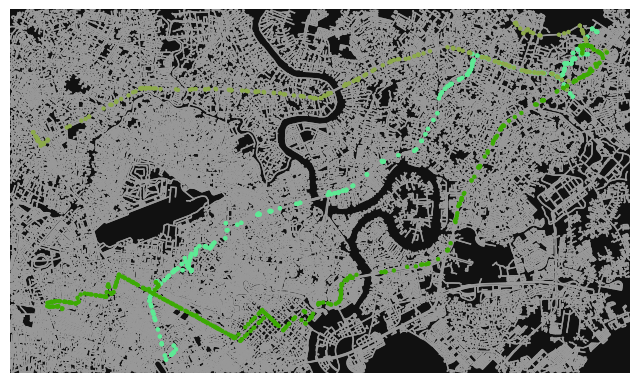

In [7]:
tmp_scatters = list()
for bus in buses:
    r = lambda: mu.rd.randint(0,255)
    color = f"#{r():02x}{r():02x}{r():02x}"
    for var in bus.vars:
        tmp_scatters.append(ax.scatter(bus.x[var], bus.y[var], s=10, c=color, alpha=1, edgecolor="none"))
ax.figure

In [8]:
for tmp in tmp_scatters:
    tmp.remove()
tmp_scatters.clear()

In [19]:
env = sp.Environment()
ONE_DAY_IN_SEC = 60*60*24
PLOT_INTERVAL = 60*15
scatters = list()
colors = dict()

def get_random_color():
    r = lambda: mu.rd.randint(0,255)
    color = f"#{r():02x}{r():02x}{r():02x}"
    return color


for bus in bus_ids:
    if bus in colors: continue

    color_set = set([colors[var] for var in colors])
    color = get_random_color()
    while color in color_set:
        color = get_random_color()
    colors[bus] = color


def start_simulation():
    while True:
        for bus in buses:
            bus.setup(env, ONE_DAY_IN_SEC)
            env.process(bus.start_schedule(bus.vars[0], bus.vars[1]))
            env.process(bus.start_schedule(bus.vars[1], bus.vars[0]))
        yield env.timeout(ONE_DAY_IN_SEC)
        

def plot_data(interval):
    global scatters, colors
    while True:
        yield env.timeout(interval)
        display(ax.figure)
        clear_output(wait=True)
        if len(scatters) > 0:
            for scatter in scatters:
                scatter.remove()
            scatters.clear()

        x_values, y_values = BusModel.get_coord()
        routes = x_values.keys()
        for route in routes:
            scatters.append(ax.scatter(x_values[route], y_values[route], s=10, c=colors[route]))

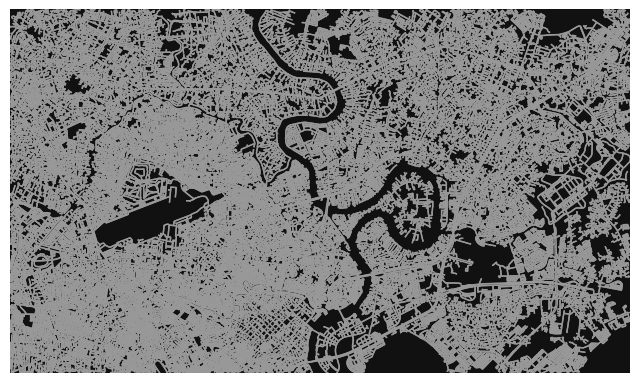

In [20]:
try:
    env.process(plot_data(PLOT_INTERVAL))
    env.process(start_simulation())
    env.run(until=1 * ONE_DAY_IN_SEC)
finally:
    for scatter in scatters:
        scatter.remove()
    scatters.clear()
    colors.clear()